##### GLDADec (Our Proposed) deconvolution on TCGA-BRCA
- TCGA RNA-seq data were downloaded on November 16, 2022. 
- Due to memory problems, some files are not registered in this repository.Please contact us if necessary.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = '/workspace/github/GLDADec' # cloning repository
import sys
sys.path.append(BASE_DIR)

from run import pipeline
from _utils import tcga_utils as tu

***
#### Load data

In [2]:
raw_df = pd.read_csv('/workspace/Topic_Deconv/GuidedLDA/230608_TCGA/230608_BRCA_analysis/230608_conduct_deconv/results/53561x1052_tmp.csv',index_col=0) # local data

breast_dic = pd.read_pickle(BASE_DIR+'/data/marker/human_breast_CellMarker.pkl')
random_sets = pd.read_pickle(BASE_DIR+'/data/random_info/100_random_sets.pkl')

***
#### Conduct GLDADec
- We added 100 genes with large coefficients of variation between samples.
- Distributions of each sample was normalized with QN.

  0%|          | 0/10 [00:00<?, ?it/s]

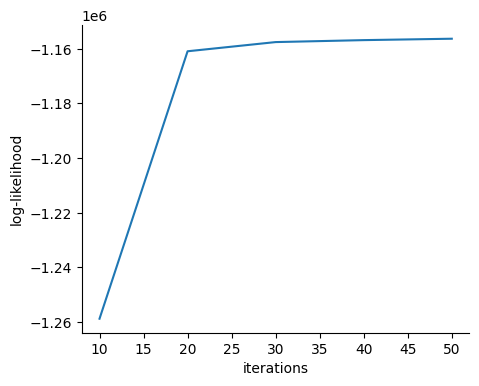

In [3]:
pp = pipeline.Pipeline(verbose=False)
pp.from_predata(raw_df,target_samples=[],
                do_ann=False,linear2log=False,log2linear=False,do_drop=True,do_batch_norm=False,do_quantile=True)
pp.gene_selection(method='CV',outlier=False,topn=100)
pp.add_marker_genes(target_cells=[],add_dic=breast_dic)
pp.deocnv_prep(random_sets=random_sets,do_plot=False,specific=True,prior_norm=True,norm_scale=1000,minmax=False,mm_scale=10)
pp.deconv(n=10,add_topic=1,n_iter=50,alpha=0.01,eta=0.01,refresh=10,initial_conf=1.0,seed_conf=1.0,other_conf=0.0,ll_plot=True,var_plot=False)

In [4]:
merge_res = pp.merge_total_res
deconv_res = sum(merge_res) / len(merge_res)

***
#### BRCA subtype classification

In [5]:
brca_res = deconv_res.rename(columns={'1':'others'}) # rename

sample2id = pd.read_pickle(BASE_DIR+'/data/TCGA/sample2caseid_dic.pkl')
barcode2id = pd.read_pickle(BASE_DIR+'/data/TCGA/barcode2caseid_dic.pkl')

new_idx = [sample2id.get(x) for x in brca_res.index.tolist()]
brca_res.index = new_idx

info = pd.read_excel(BASE_DIR+'/data/TCGA/pone.0157368.s008.xlsx',index_col=0)
target_type = ['Basal','Her2','LumA','LumB','Normal']

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


/tmp/ipykernel_2056827/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_res['type']=[t]*len(common_res)
/tmp/ipykernel_2056827/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_res['type']=[t]*len(common_res)
/tmp/ipykernel_2056827/2061561079.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

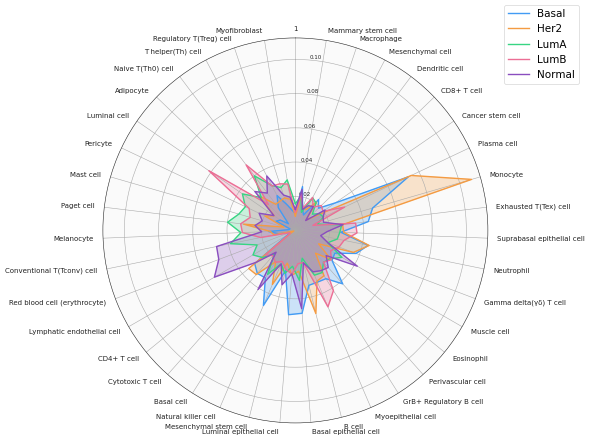

In [6]:
data = []
summary_res = pd.DataFrame()
for t in target_type:
    tmp_df = info[info['PAM50']==t]

    target_caseid = []
    for b in tmp_df.index.tolist():
        for i,k in enumerate(barcode2id):
            if b in k:
                target_caseid.append(barcode2id.get(k))
            else:
                pass

    common_res = brca_res.loc[brca_res.index.isin(target_caseid)]
    common_v = common_res.mean()
    data.append(common_v)

    common_res['type']=[t]*len(common_res)
    summary_res = pd.concat([summary_res,common_res])

# radar chart
tu.plot_radar(data=data,labels=brca_res.columns.tolist(),conditions=target_type,title='',figsize=(10,10),dpi=50)


In [7]:
""" Each subtype can be compared in a bar chart.
# violon plot
for cell in summary_res.columns.tolist()[0:-1]:
    fig = plt.figure(figsize=(6,6),dpi=50)
    ax = fig.add_subplot(1, 1, 1)
    #sns.violinplot(data=summary_res,x='type',y=cell, inner='quartile', cut=0, scale="area",linewidth=1.5)
    sns.boxplot(data=summary_res,x='type',y=cell)
    plt.setp(ax.collections, alpha=.75)
    #sns.stripplot(data=summary_res, x='type', y=cell, jitter=True, hue='type', linewidth=0.5, size=2, color='k')
    ax.set_title(cell,fontsize=15)
    ax.grid(color="#ababab",linewidth=0.5)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.xticks(rotation=75)
    plt.ylabel('')
    plt.xlabel('')
    #ax.get_legend().remove()
    ax.set_axisbelow(True)
    plt.show()
"""

' Each subtype can be compared in a bar chart.\n# violon plot\nfor cell in summary_res.columns.tolist()[0:-1]:\n    fig = plt.figure(figsize=(6,6),dpi=50)\n    ax = fig.add_subplot(1, 1, 1)\n    #sns.violinplot(data=summary_res,x=\'type\',y=cell, inner=\'quartile\', cut=0, scale="area",linewidth=1.5)\n    sns.boxplot(data=summary_res,x=\'type\',y=cell)\n    plt.setp(ax.collections, alpha=.75)\n    #sns.stripplot(data=summary_res, x=\'type\', y=cell, jitter=True, hue=\'type\', linewidth=0.5, size=2, color=\'k\')\n    ax.set_title(cell,fontsize=15)\n    ax.grid(color="#ababab",linewidth=0.5)\n    plt.gca().spines[\'right\'].set_visible(False)\n    plt.gca().spines[\'top\'].set_visible(False)\n    plt.gca().yaxis.set_ticks_position(\'left\')\n    plt.gca().xaxis.set_ticks_position(\'bottom\')\n    plt.xticks(rotation=75)\n    plt.ylabel(\'\')\n    plt.xlabel(\'\')\n    #ax.get_legend().remove()\n    ax.set_axisbelow(True)\n    plt.show()\n'

***
#### Survival analysi on BRCA patients.
- Tumor samples were sorted according to the estimated proportion of specific cell types, and Cox proportional hazards regression was used to calculate survival rates between the top and bottom 25% of the samples.

In [8]:
brca_df = pd.read_table('/workspace/TCGA/tpm/TPM_TCGA-BRCA.txt',index_col=0) # local data
clinical = pd.read_table('/workspace/TCGA/info/clinical.tsv') # local data

# comprehensive analysis
dat = tu.TCGA_Analysis()
dat.set_data(exp=brca_df,deconv_res=deconv_res,clinical=clinical)
dat.preprocessing(lower_days=0,upper_days=3650)
summary = pd.DataFrame()
for cell in deconv_res.columns:
    dat.calc_top_bottom(cell=cell,do_plot=False) # top 25% and bottom 25%
    res_log = dat.res_log
    summary = pd.concat([summary,res_log])
summary.index = deconv_res.columns
summary = summary.sort_values('log-rank')

/workspace/github/GLDADec/_utils/tcga_utils.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Time"] = prognosis["OS_Time"].apply(fxn)
/workspace/github/GLDADec/_utils/tcga_utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Status"] = prog_status


/workspace/github/GLDADec/_utils/tcga_utils.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Time"] = prognosis["OS_Time"].apply(fxn)
/workspace/github/GLDADec/_utils/tcga_utils.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prognosis["OS_Status"] = prog_status


<lifelines.CoxPHFitter: fitted with 393 total observations, 376 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 17
   partial log-likelihood = -78.59
         time fit was run = 2023-12-27 06:05:03 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Mesenchymal cell   2.20       9.04       0.75             0.72             3.68                 2.06                39.60

                   cmp to    z      p   -log2(p)
covariate                                       
Mesenchymal cell     0.00 2.92 <0.005       8.16
---
Concordance = 0.65
Partial AIC = 159.19
log-likelihood ratio test = 13.76 on 1 df
-log2(p) of ll-ratio test = 12.23

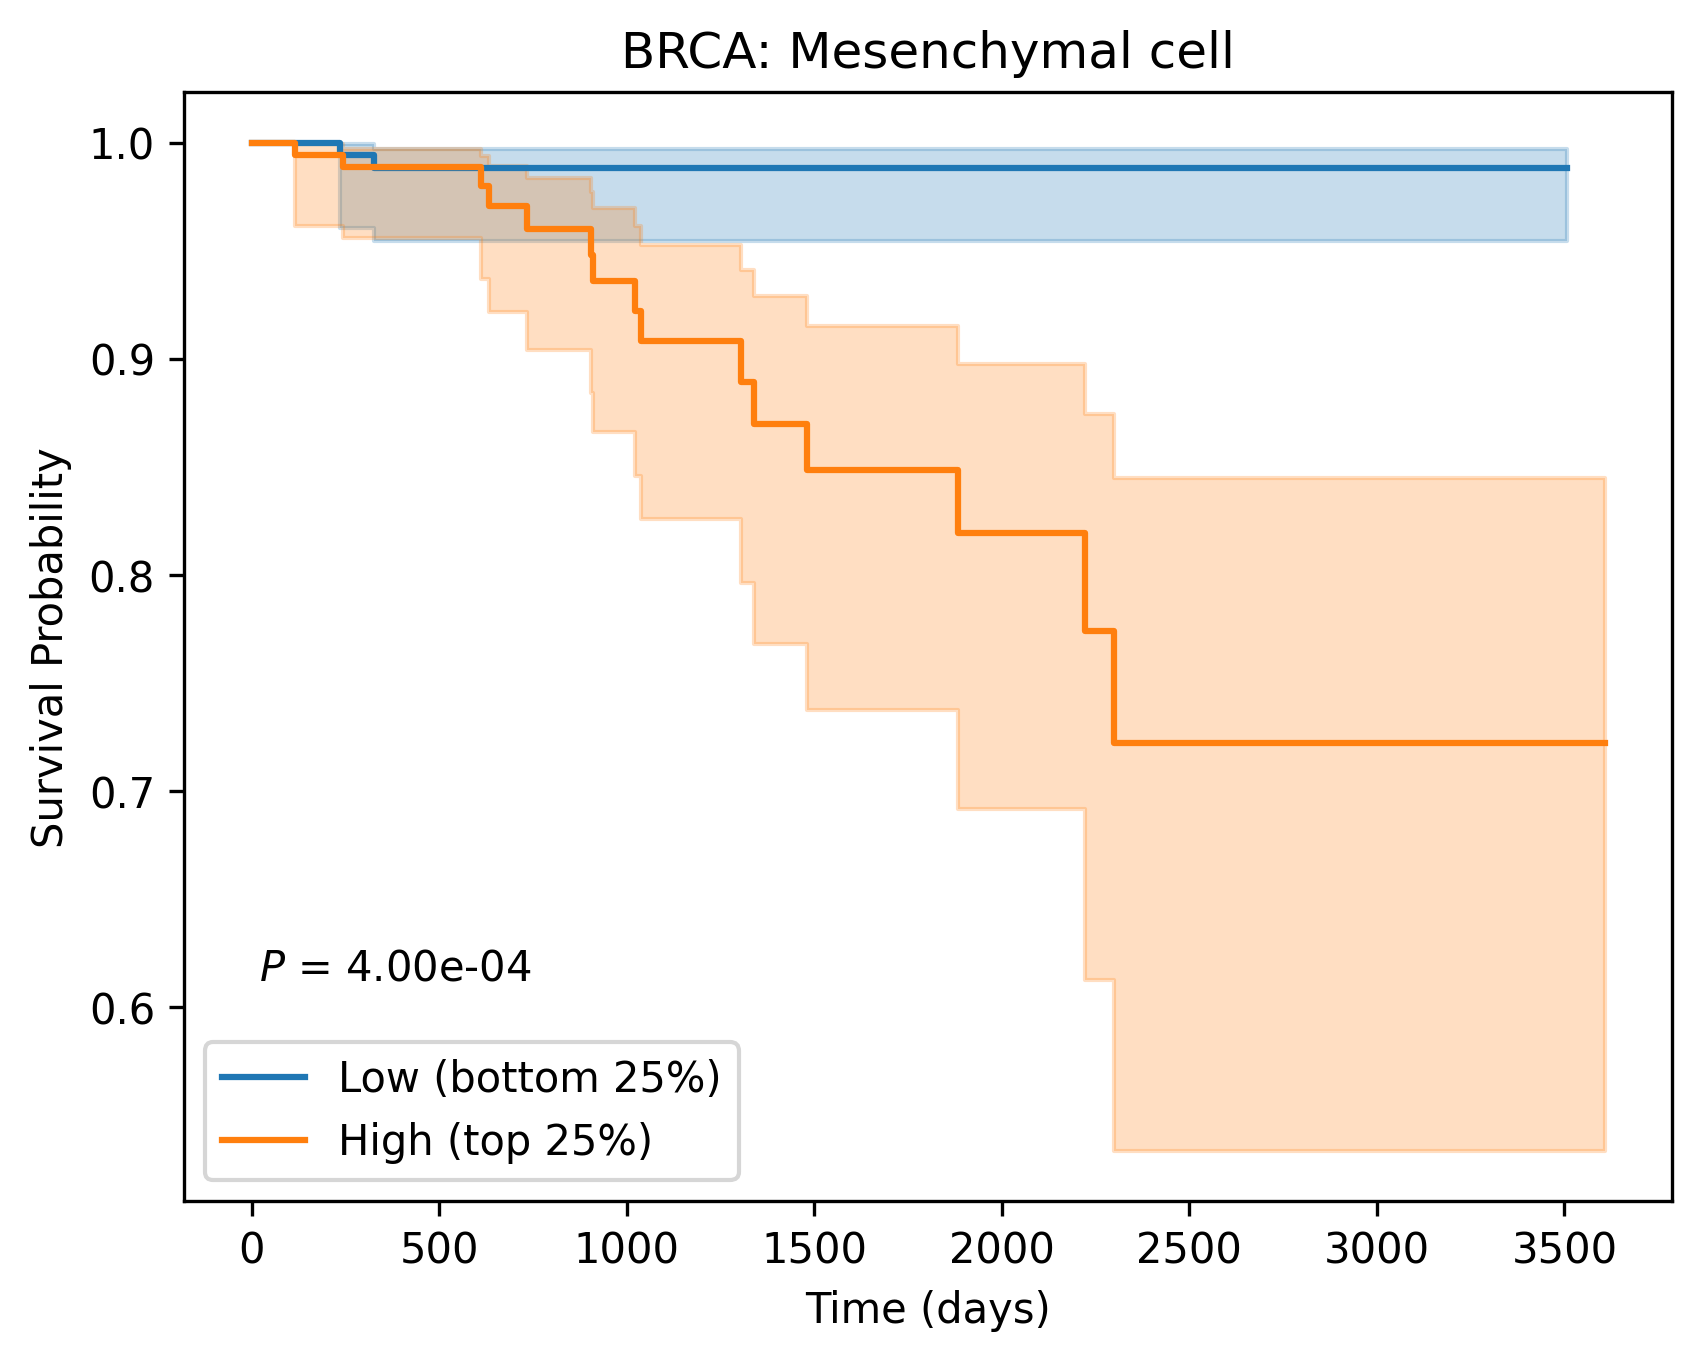

<lifelines.CoxPHFitter: fitted with 393 total observations, 377 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 16
   partial log-likelihood = -72.53
         time fit was run = 2023-12-27 06:05:03 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Pericyte    2.14       8.48       0.76             0.65             3.62                 1.92                37.39

            cmp to    z      p   -log2(p)
covariate                                
Pericyte      0.00 2.83 <0.005       7.73
---
Concordance = 0.64
Partial AIC = 147.05
log-likelihood ratio test = 12.52 on 1 df
-log2(p) of ll-ratio test = 11.28

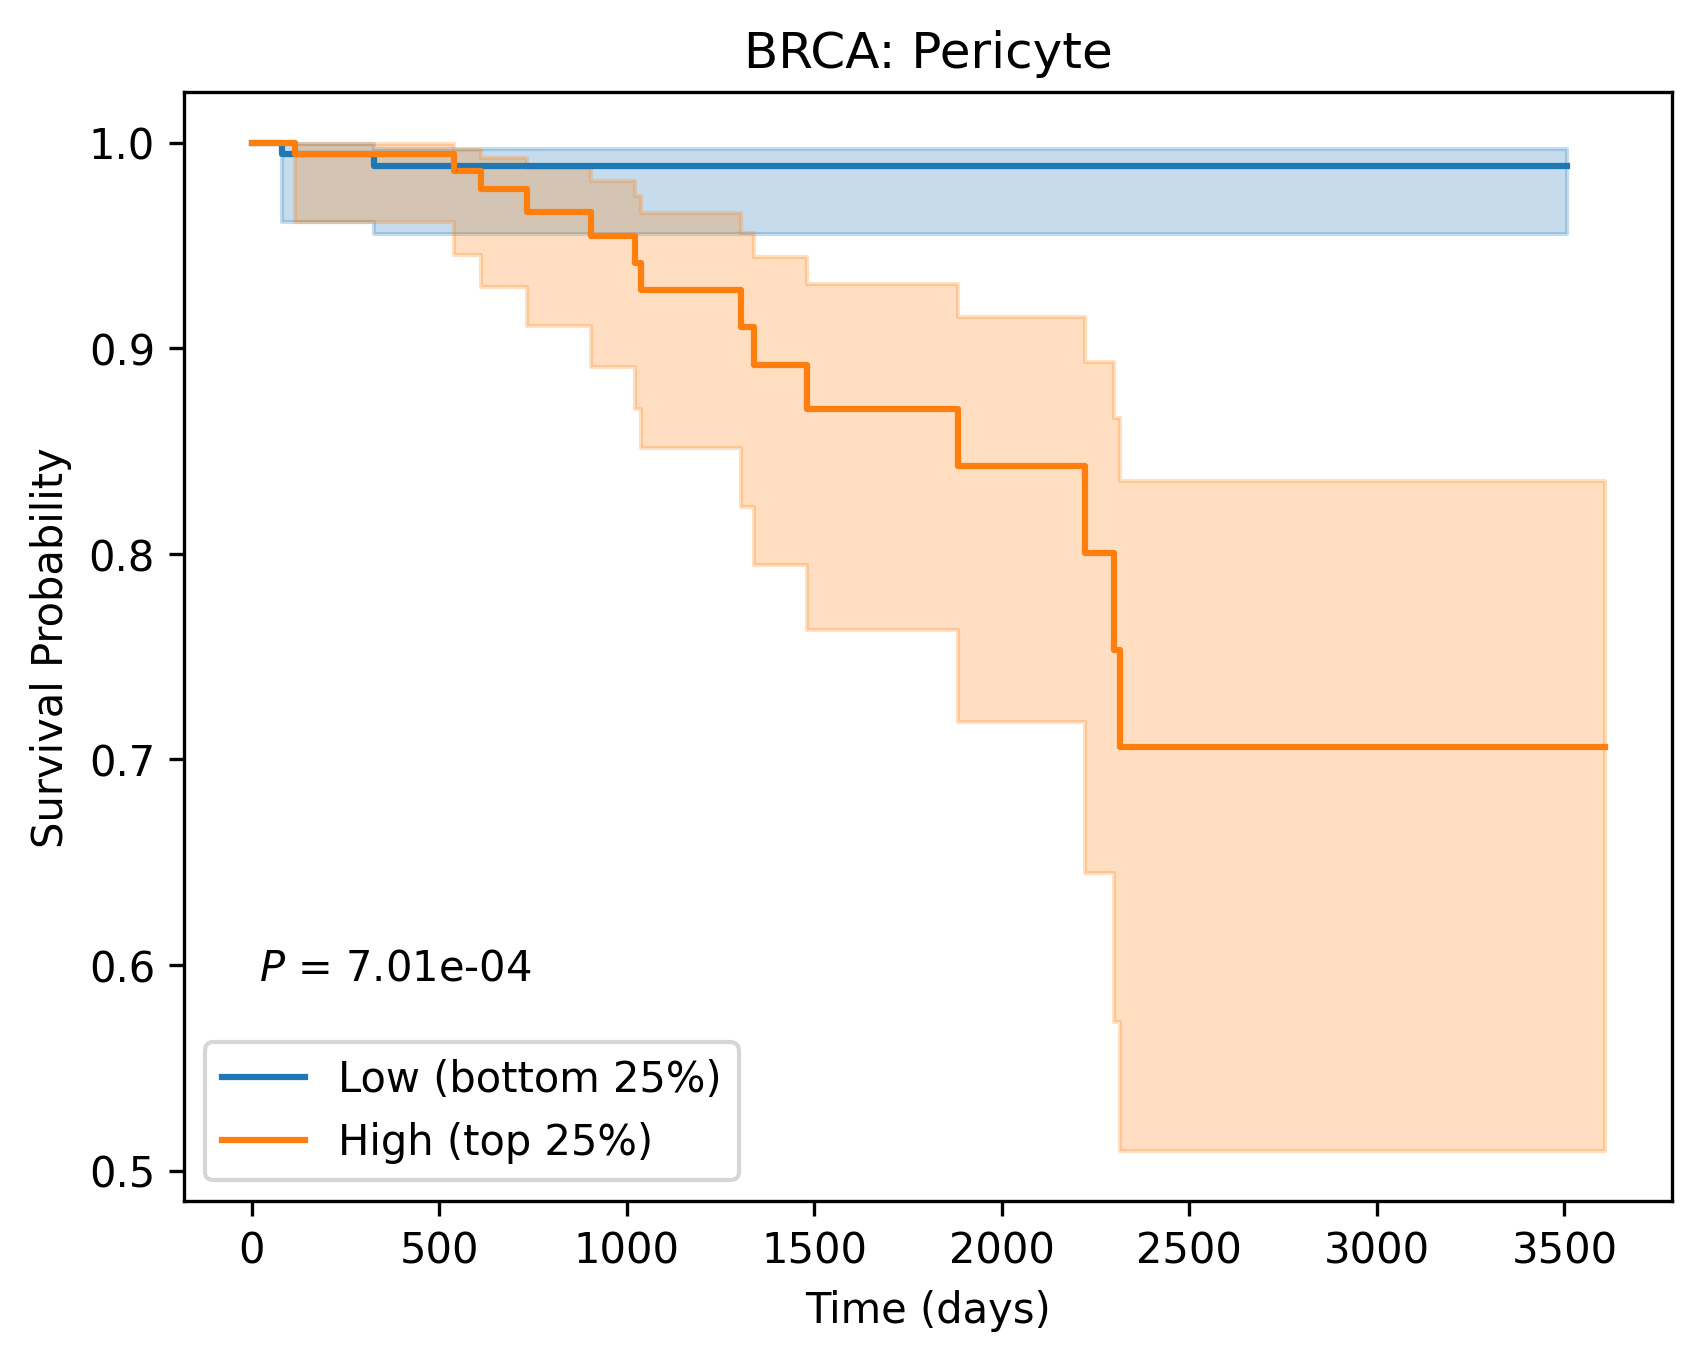

<lifelines.CoxPHFitter: fitted with 393 total observations, 376 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 17
   partial log-likelihood = -84.18
         time fit was run = 2023-12-27 06:05:04 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
Gamma delta(γδ) T cell  -1.85       0.16       0.64            -3.11            -0.59                 0.04                 0.56

                         cmp to     z      p   -log2(p)
covariate                                              
Gamma delta(γδ) T cell     0.00 -2.87 <0.005       7.94
---
Concordance = 0.67
Partial AIC = 170.35
log-likelihood ratio test = 11.15 on 1 df
-log2(p) of ll-ratio test = 10.22

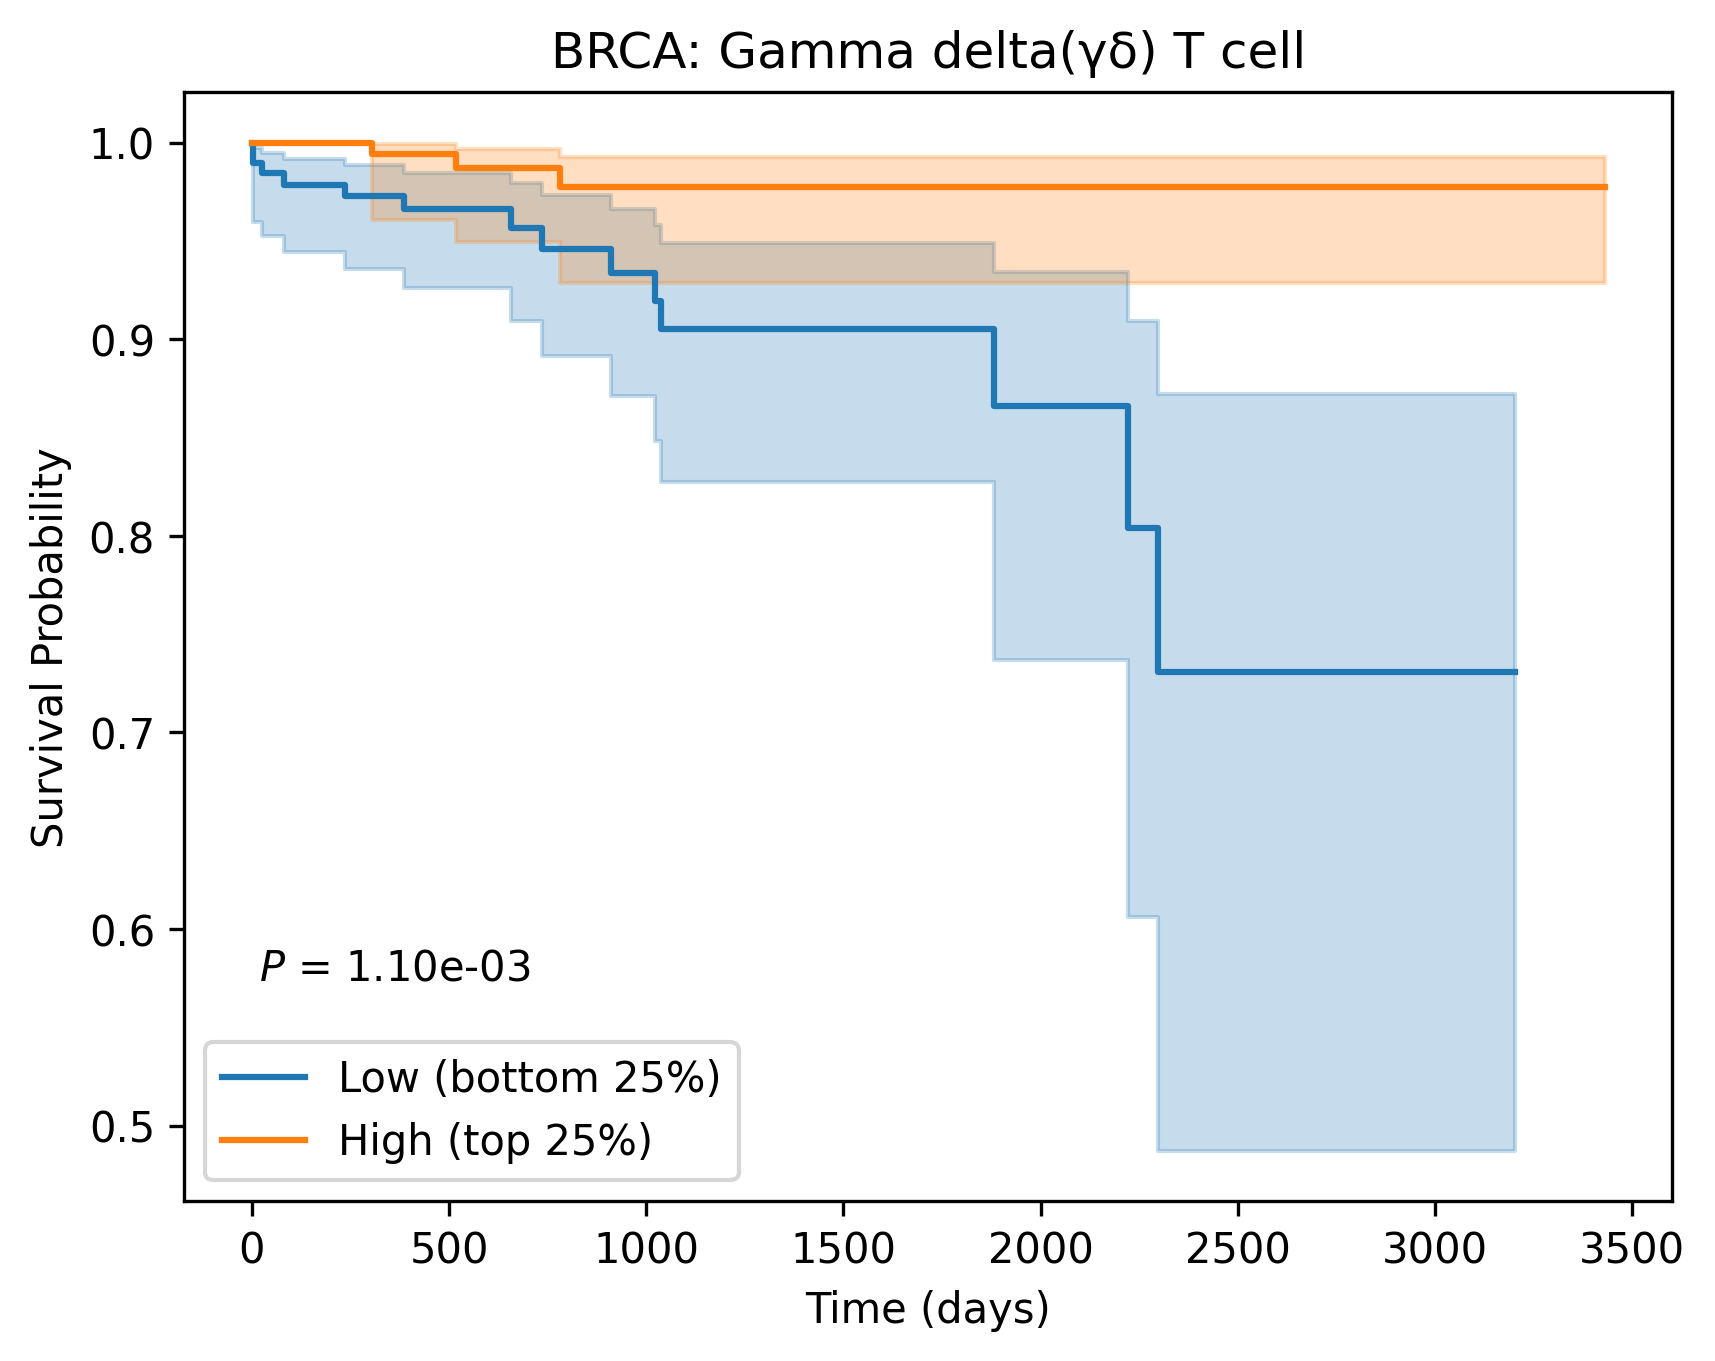

<lifelines.CoxPHFitter: fitted with 393 total observations, 380 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 13
   partial log-likelihood = -62.24
         time fit was run = 2023-12-27 06:05:04 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Plasma cell  -2.50       0.08       1.04            -4.54            -0.46                 0.01                 0.63

              cmp to     z    p   -log2(p)
covariate                                 
Plasma cell     0.00 -2.40 0.02       5.94
---
Concordance = 0.72
Partial AIC = 126.48
log-likelihood ratio test = 11.11 on 1 df
-log2(p) of ll-ratio test = 10.18

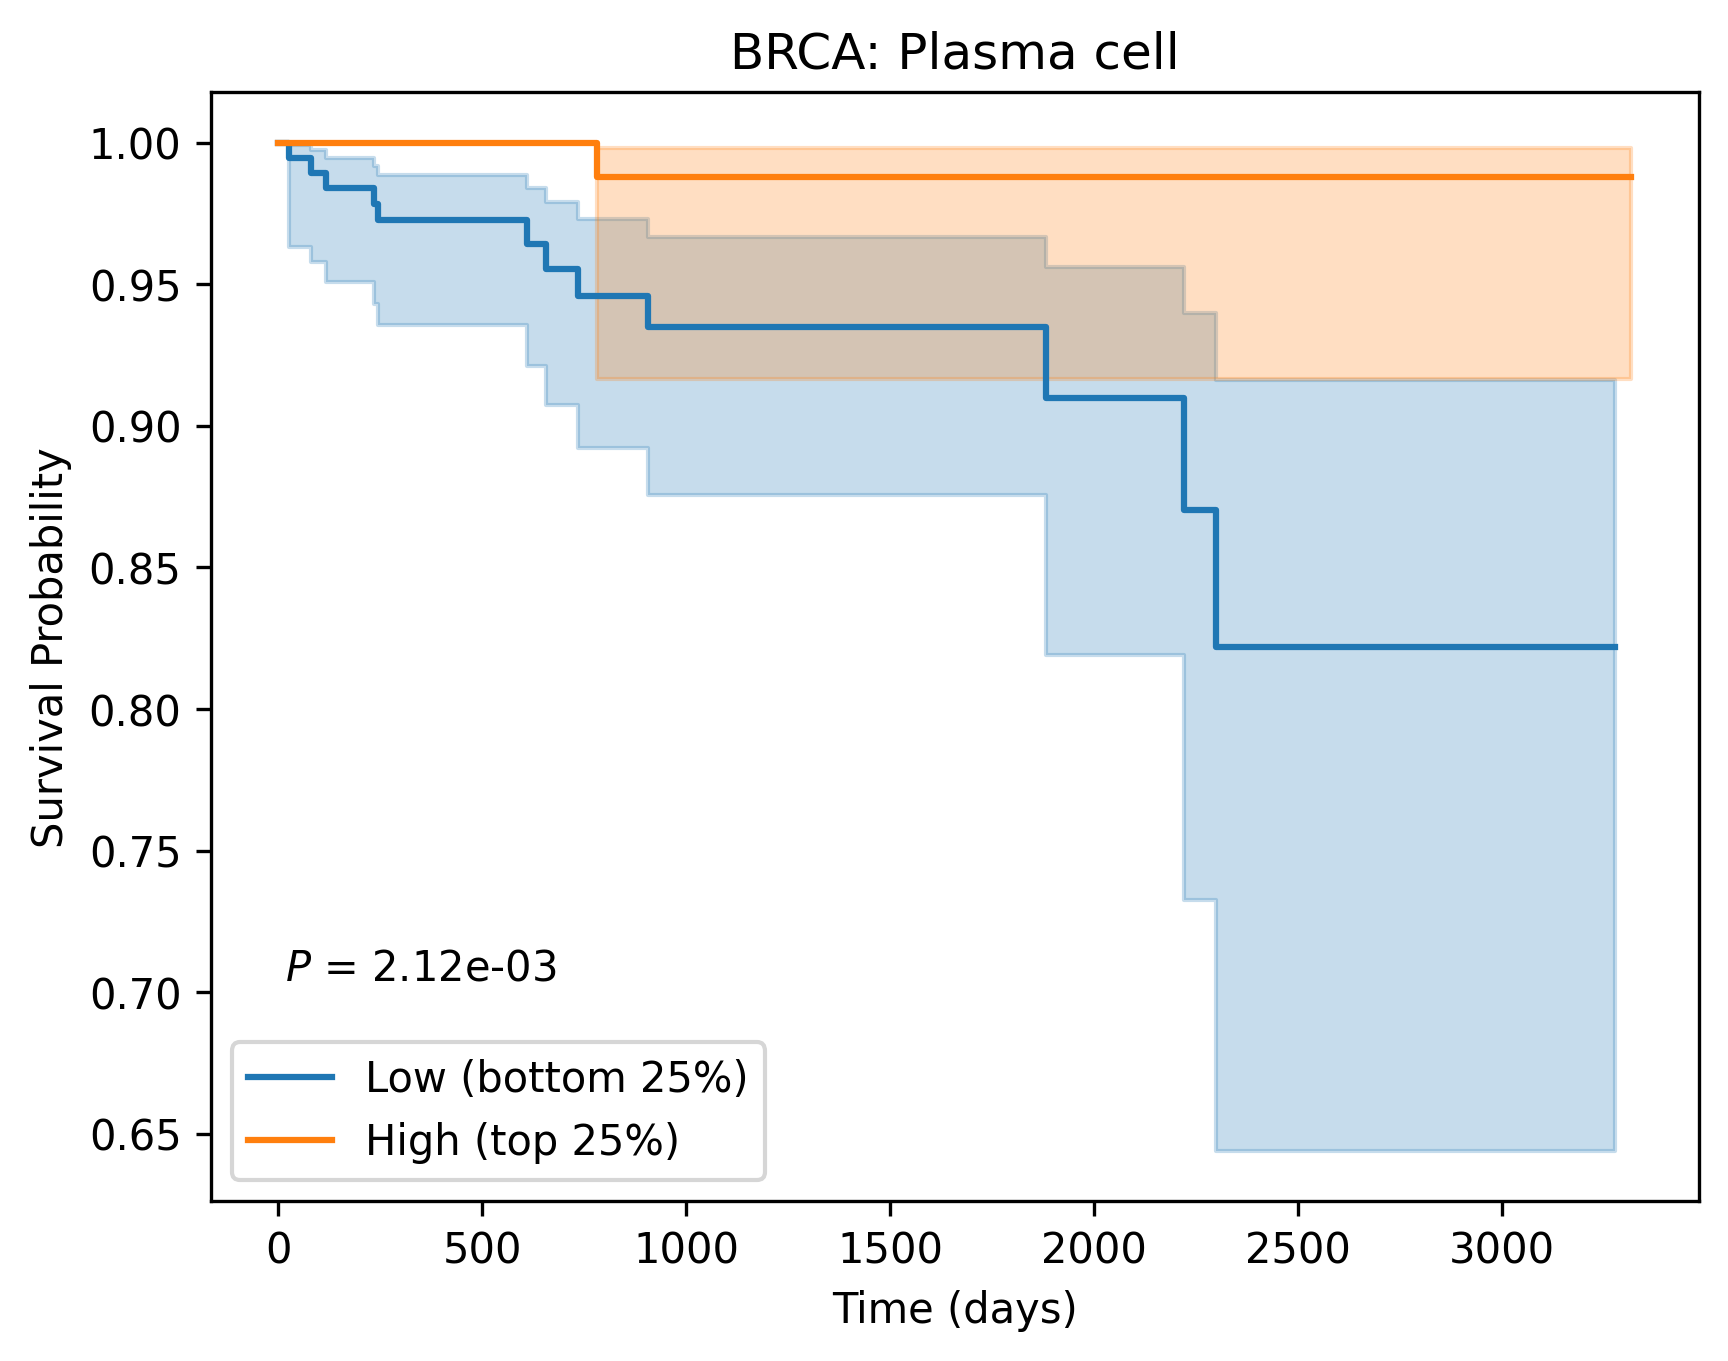

<lifelines.CoxPHFitter: fitted with 393 total observations, 381 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 12
   partial log-likelihood = -53.21
         time fit was run = 2023-12-27 06:05:05 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Mast cell   2.44      11.46       1.05             0.39             4.49                 1.48                88.88

            cmp to    z    p   -log2(p)
covariate                              
Mast cell     0.00 2.33 0.02       5.67
---
Concordance = 0.67
Partial AIC = 108.42
log-likelihood ratio test = 10.13 on 1 df
-log2(p) of ll-ratio test = 9.42

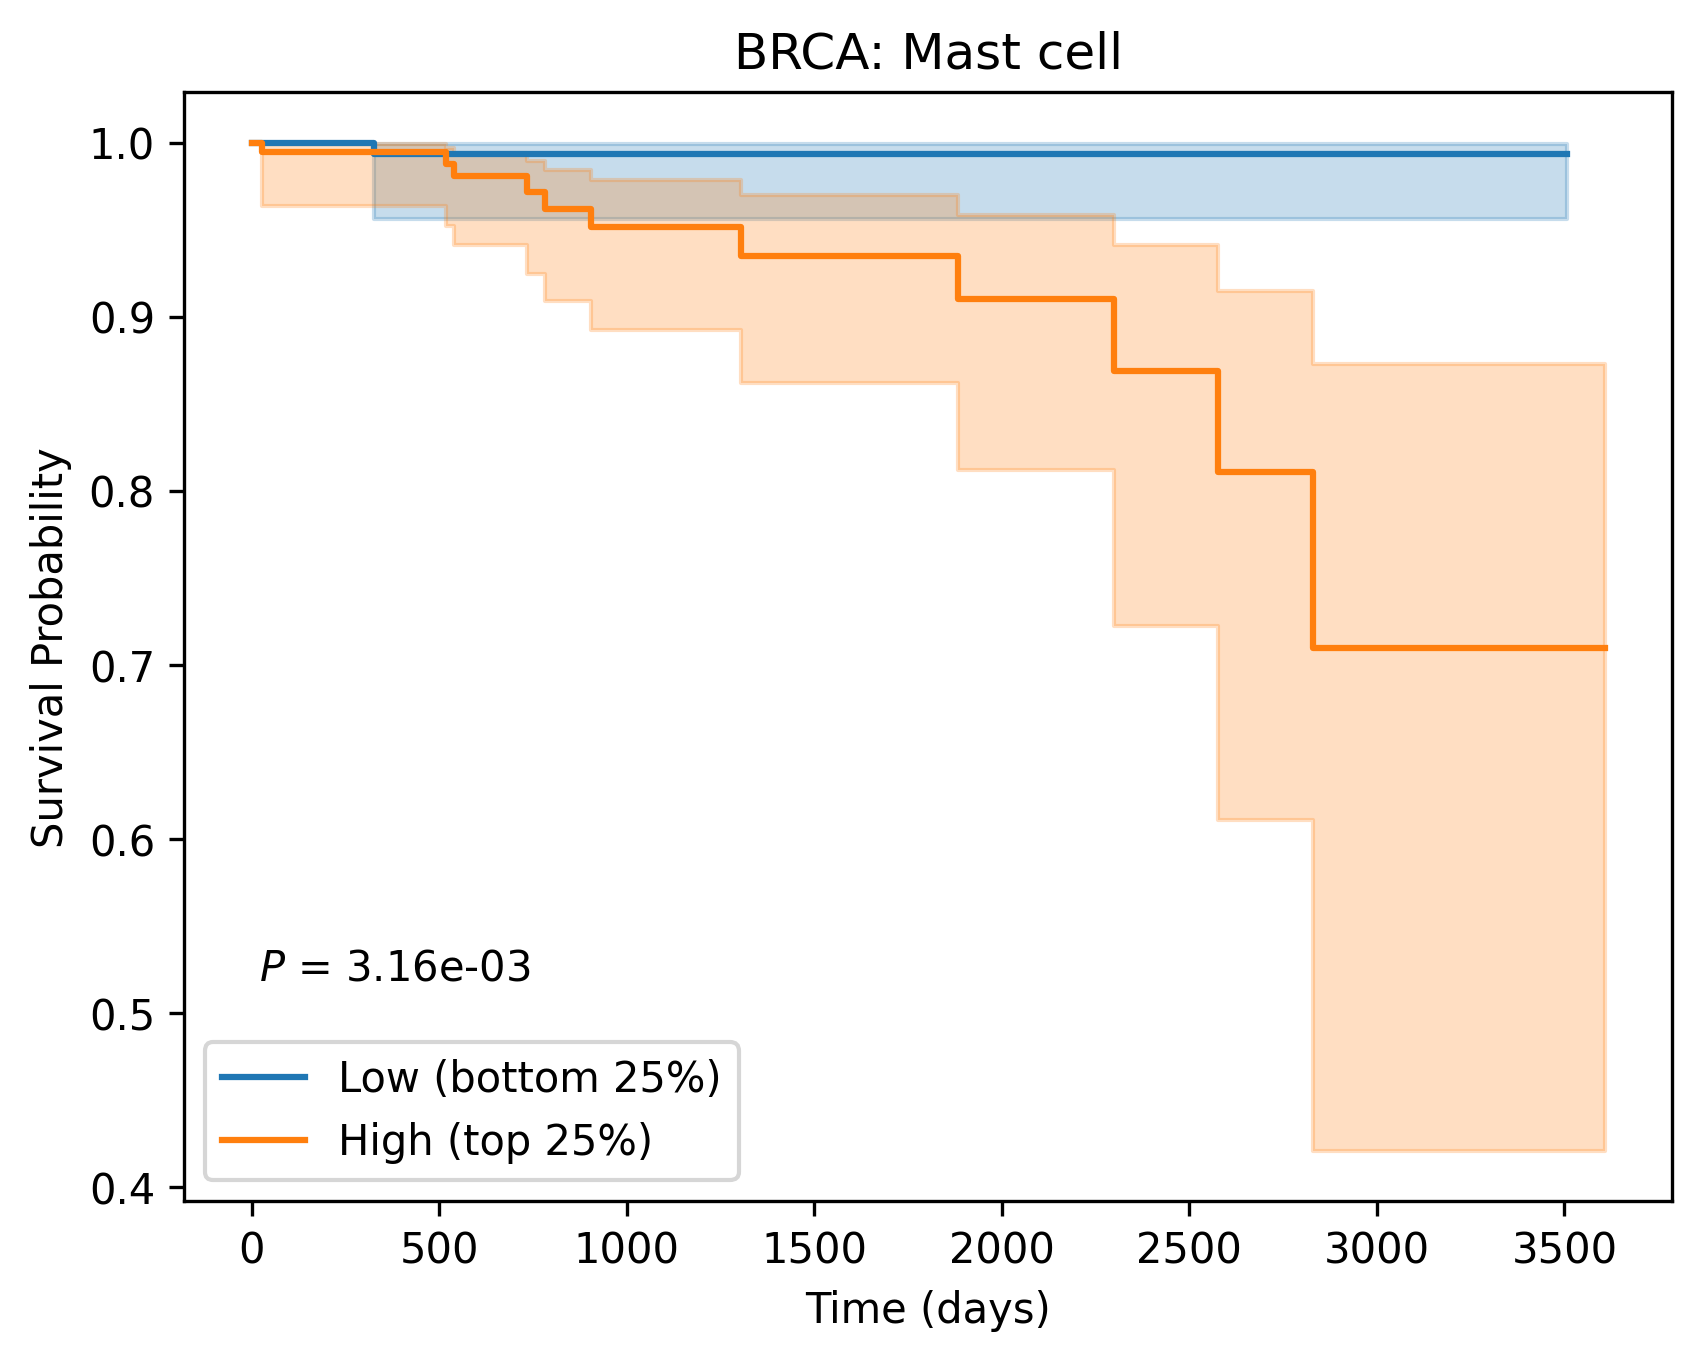

<lifelines.CoxPHFitter: fitted with 393 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 18
   partial log-likelihood = -85.69
         time fit was run = 2023-12-27 06:05:05 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Myofibroblast   1.46       4.31       0.57             0.35             2.57                 1.42                13.12

                cmp to    z    p   -log2(p)
covariate                                  
Myofibroblast     0.00 2.57 0.01       6.63
---
Concordance = 0.58
Partial AIC = 173.39
log-likelihood ratio test = 8.13 on 1 df
-log2(p) of ll-ratio test = 7.84

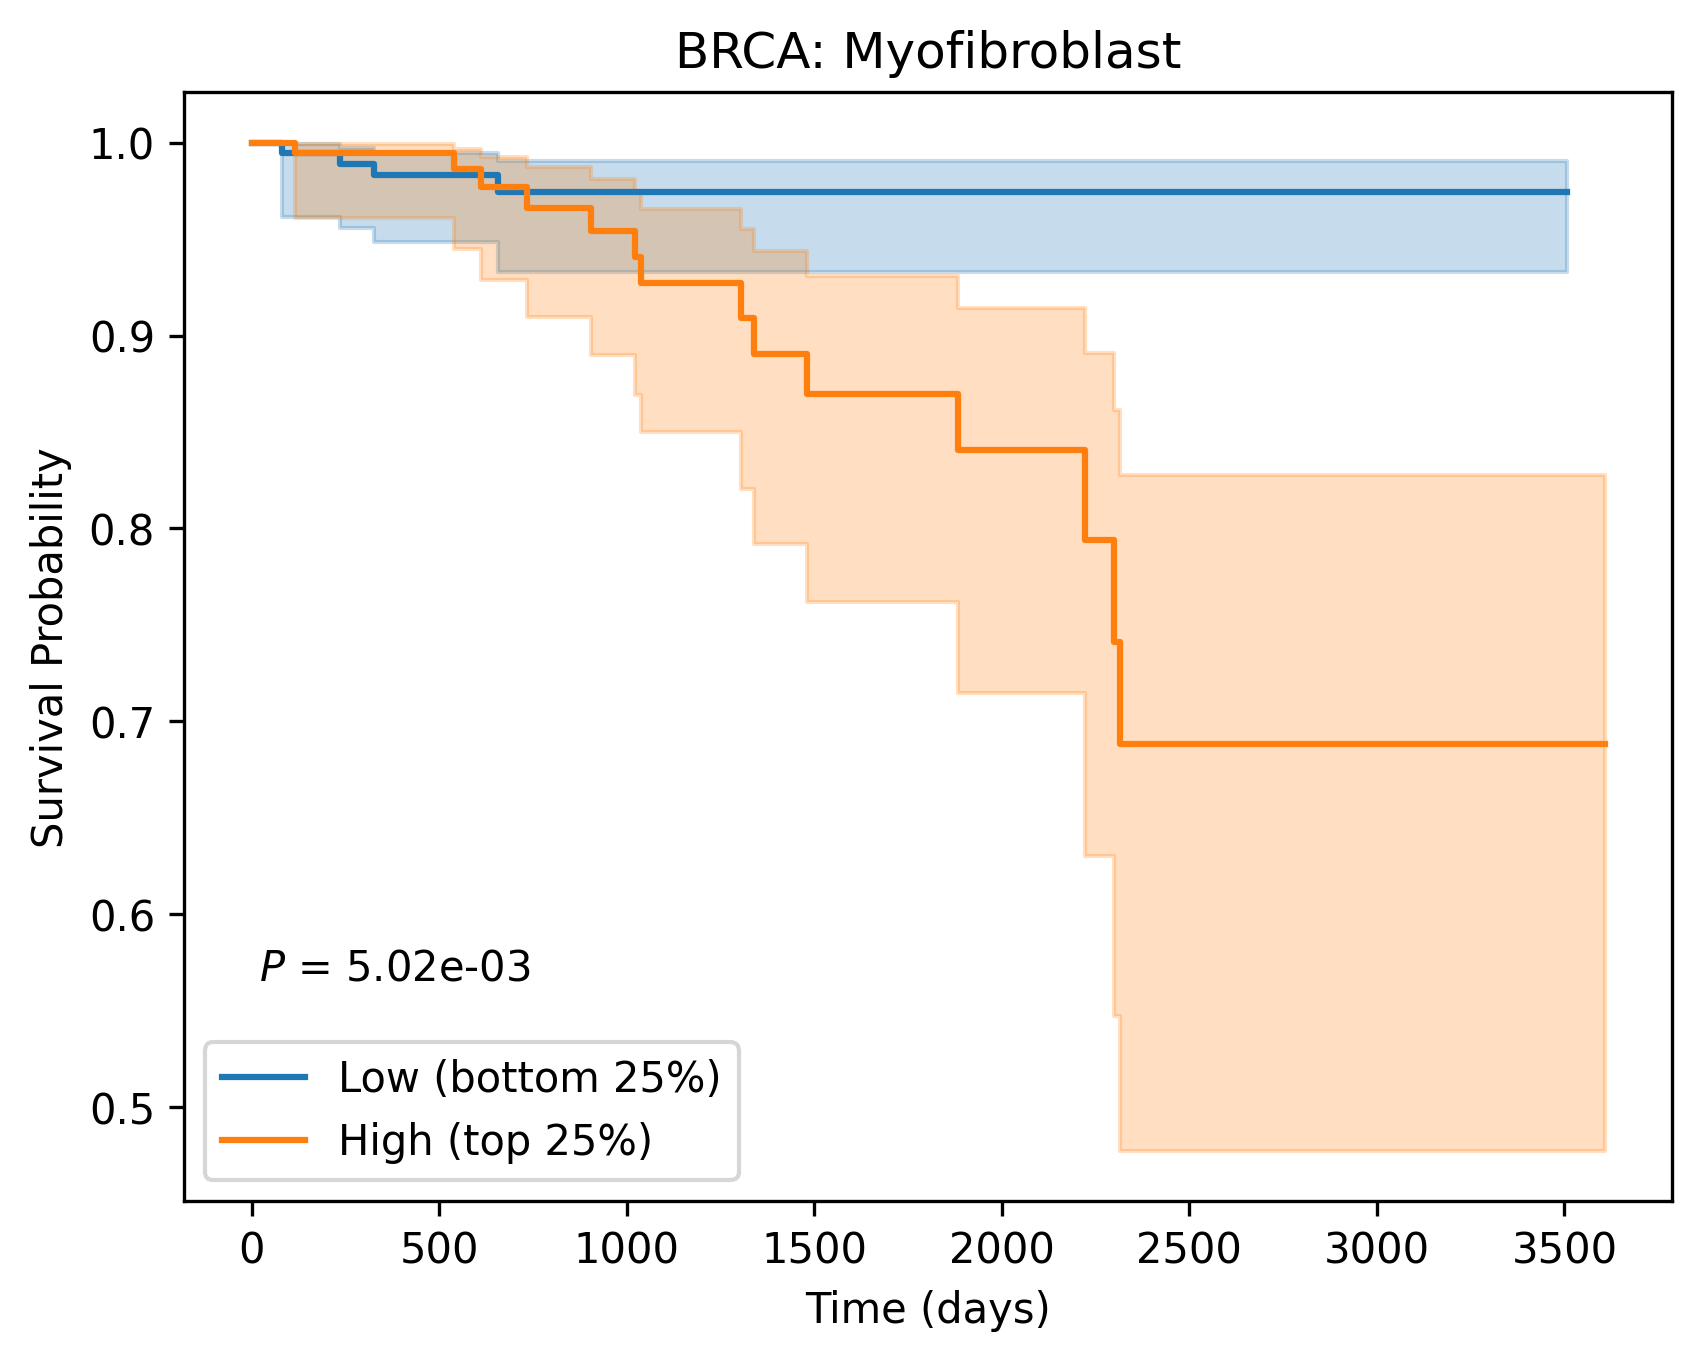

<lifelines.CoxPHFitter: fitted with 393 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 393
number of events observed = 18
   partial log-likelihood = -90.34
         time fit was run = 2023-12-27 06:05:06 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
Luminal epithelial cell  -1.56       0.21       0.63            -2.80            -0.32                 0.06                 0.72

                          cmp to     z    p   -log2(p)
covariate                                             
Luminal epithelial cell     0.00 -2.47 0.01       6.22
---
Concordance = 0.69
Partial AIC = 182.68
log-likelihood ratio test = 8.19 on 1 df
-log2(p) of ll-ratio test = 7.89

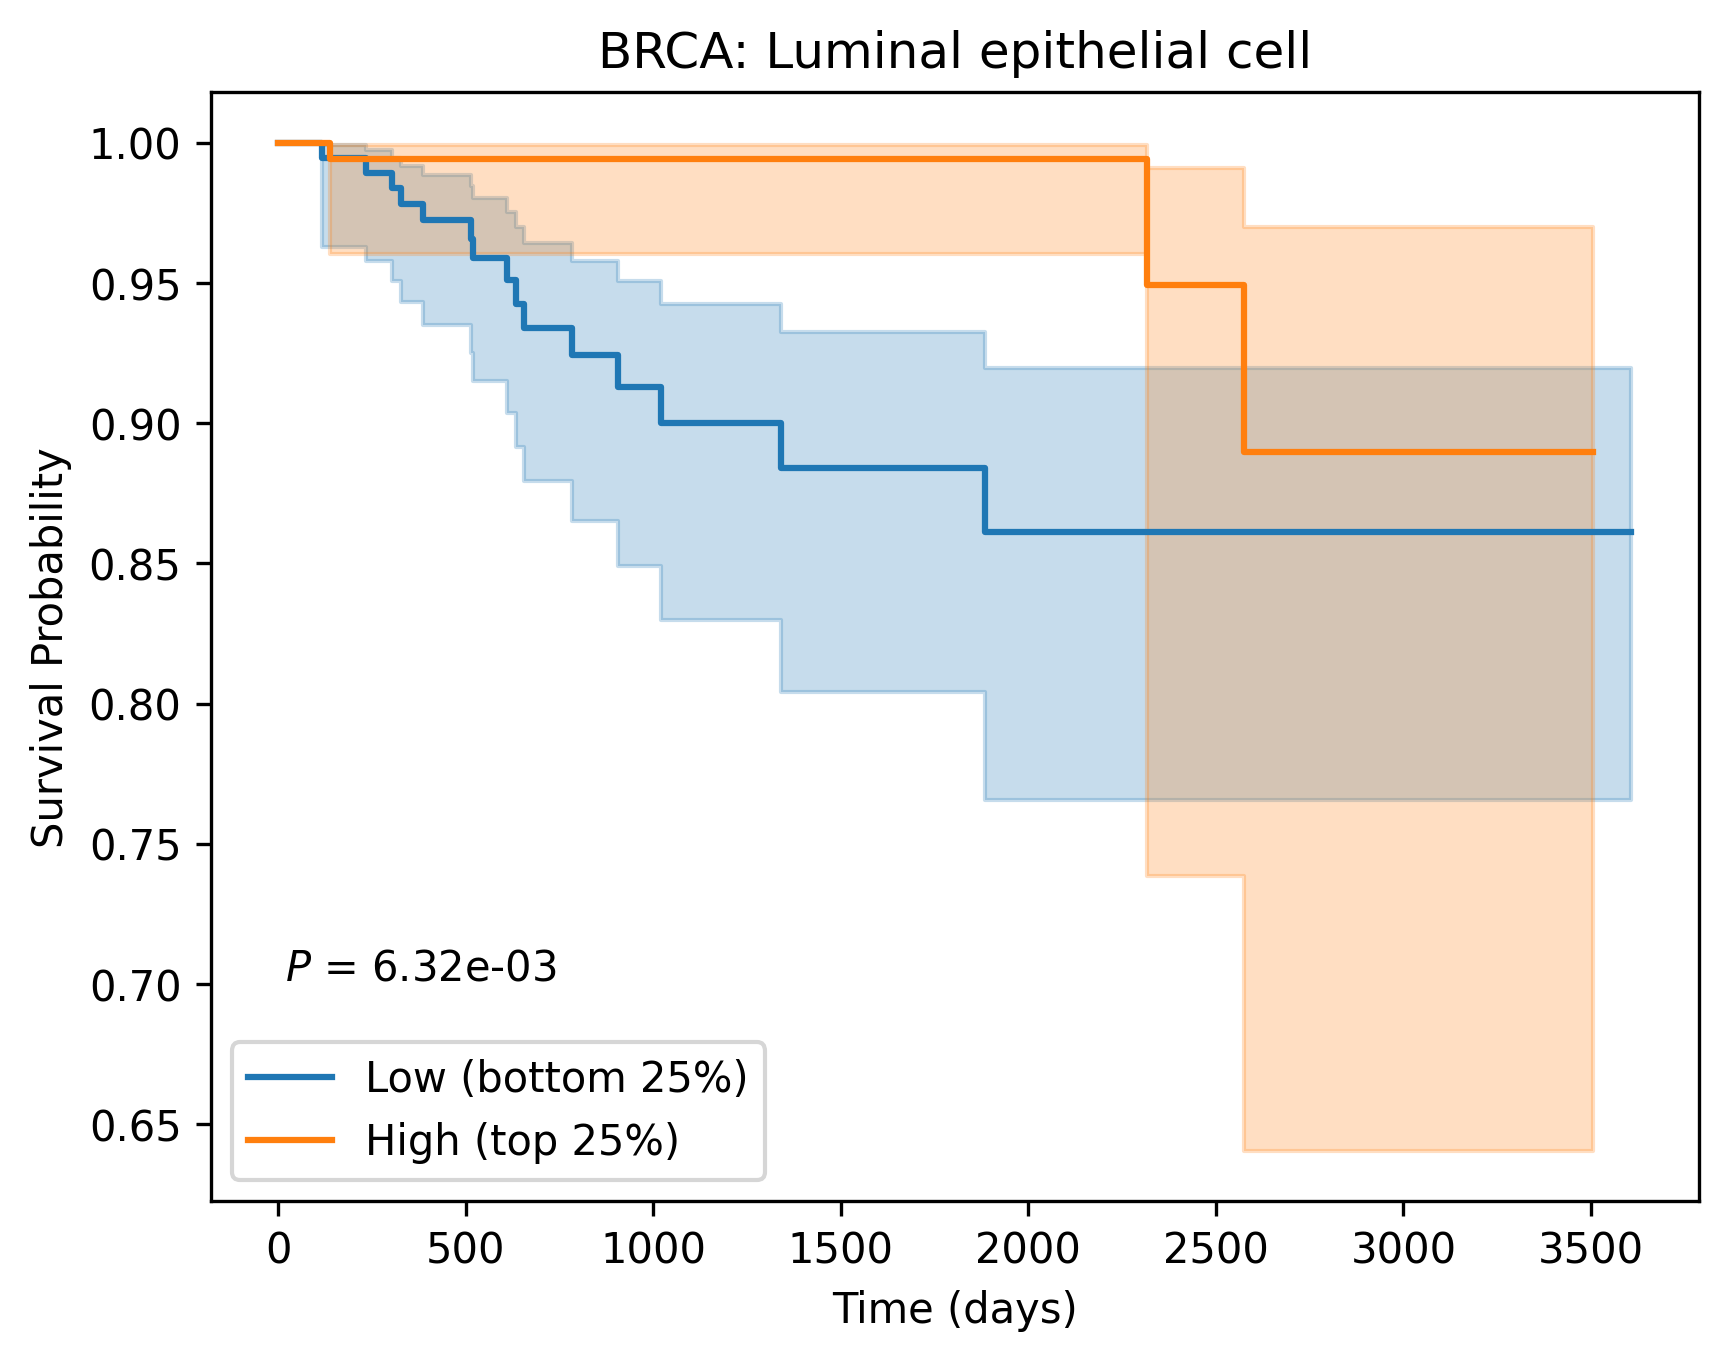

<lifelines.CoxPHFitter: fitted with 392 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 392
number of events observed = 17
   partial log-likelihood = -84.62
         time fit was run = 2023-12-27 06:05:06 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
CD4+ T cell  -1.22       0.29       0.54            -2.28            -0.17                 0.10                 0.84

              cmp to     z    p   -log2(p)
covariate                                 
CD4+ T cell     0.00 -2.28 0.02       5.45
---
Concordance = 0.58
Partial AIC = 171.24
log-likelihood ratio test = 5.79 on 1 df
-log2(p) of ll-ratio test = 5.95

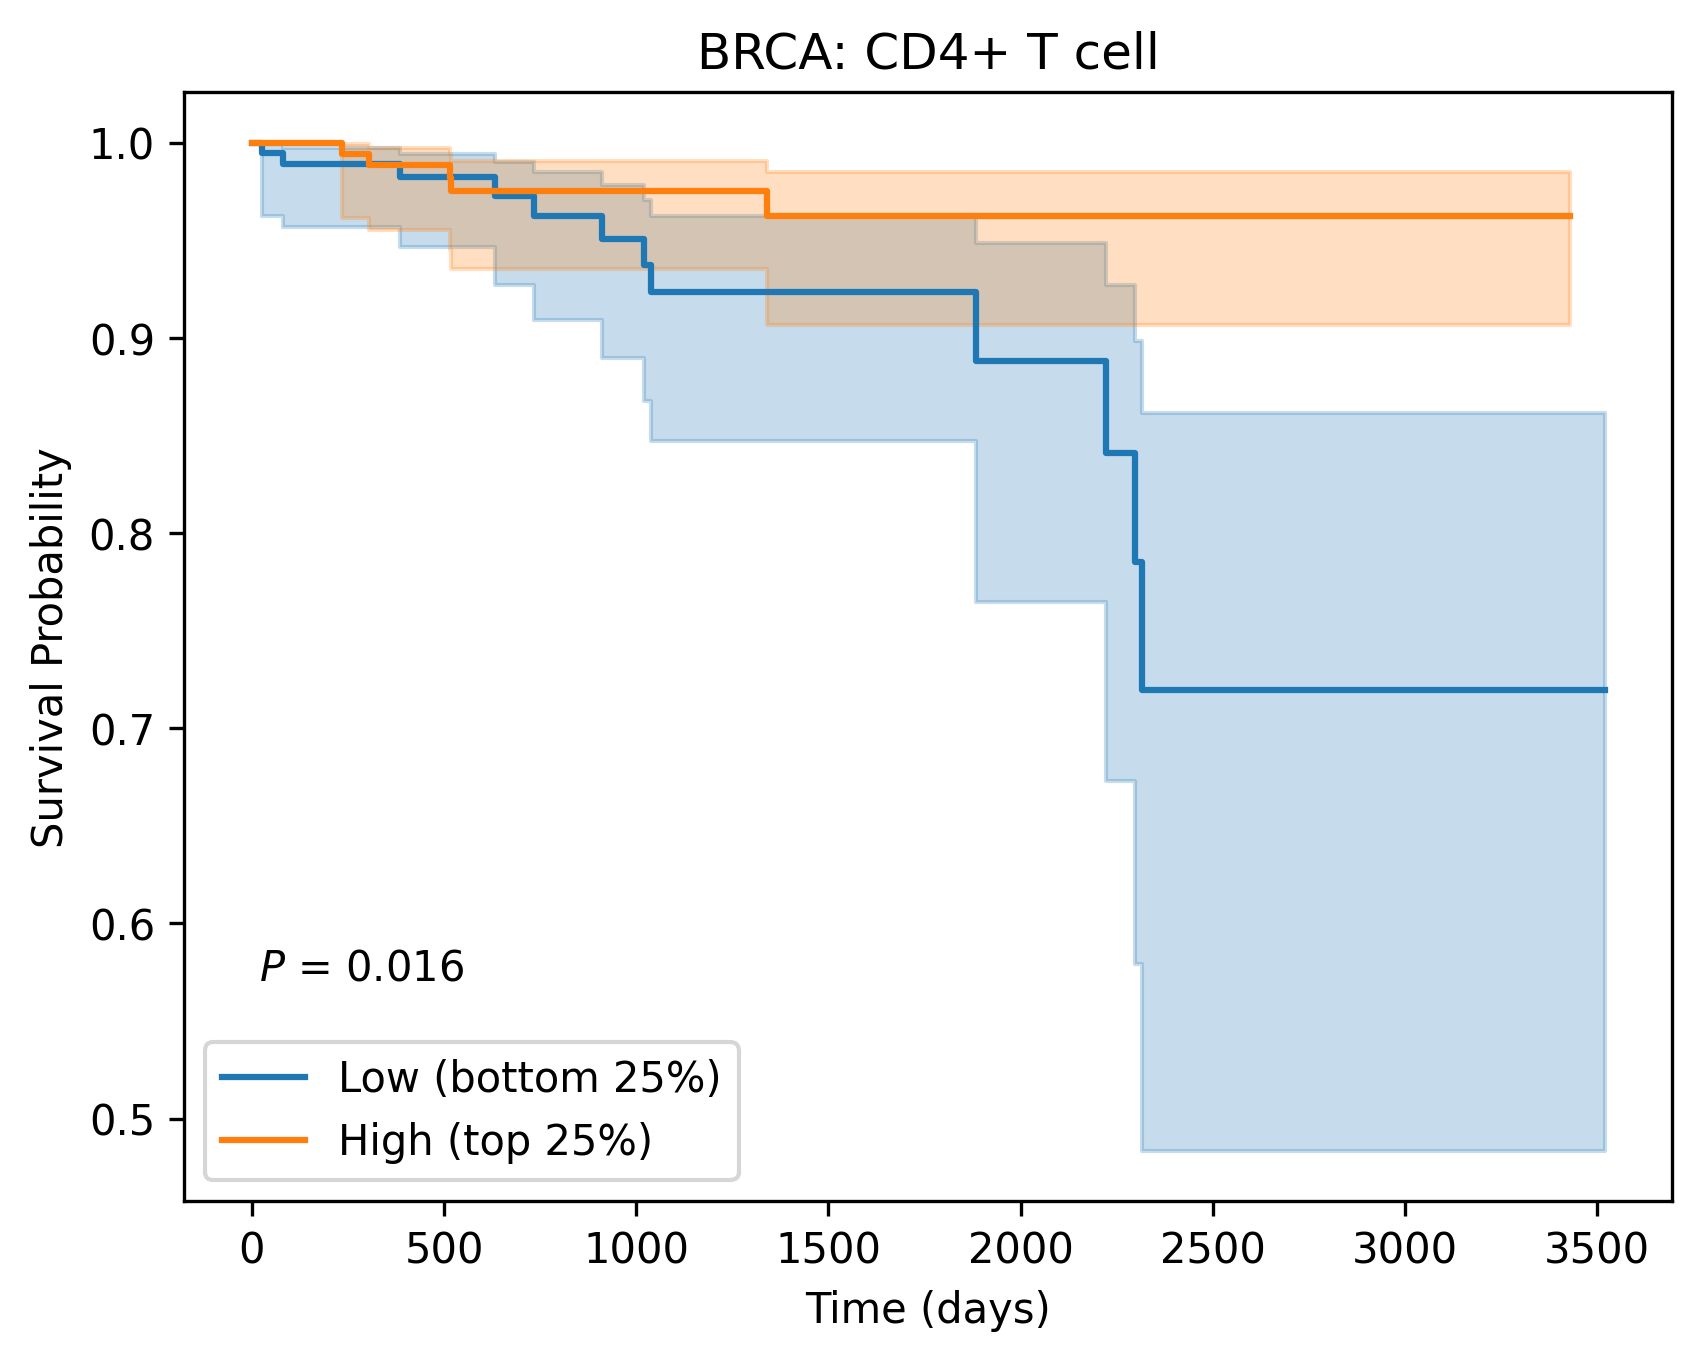

<lifelines.CoxPHFitter: fitted with 392 total observations, 375 right-censored observations>
             duration col = 'OS_Time'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 392
number of events observed = 17
   partial log-likelihood = -85.30
         time fit was run = 2023-12-27 06:05:07 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
Cytotoxic T cell  -1.22       0.30       0.54            -2.28            -0.16                 0.10                 0.85

                   cmp to     z    p   -log2(p)
covariate                                      
Cytotoxic T cell     0.00 -2.26 0.02       5.40
---
Concordance = 0.60
Partial AIC = 172.60
log-likelihood ratio test = 5.72 on 1 df
-log2(p) of ll-ratio test = 5.90

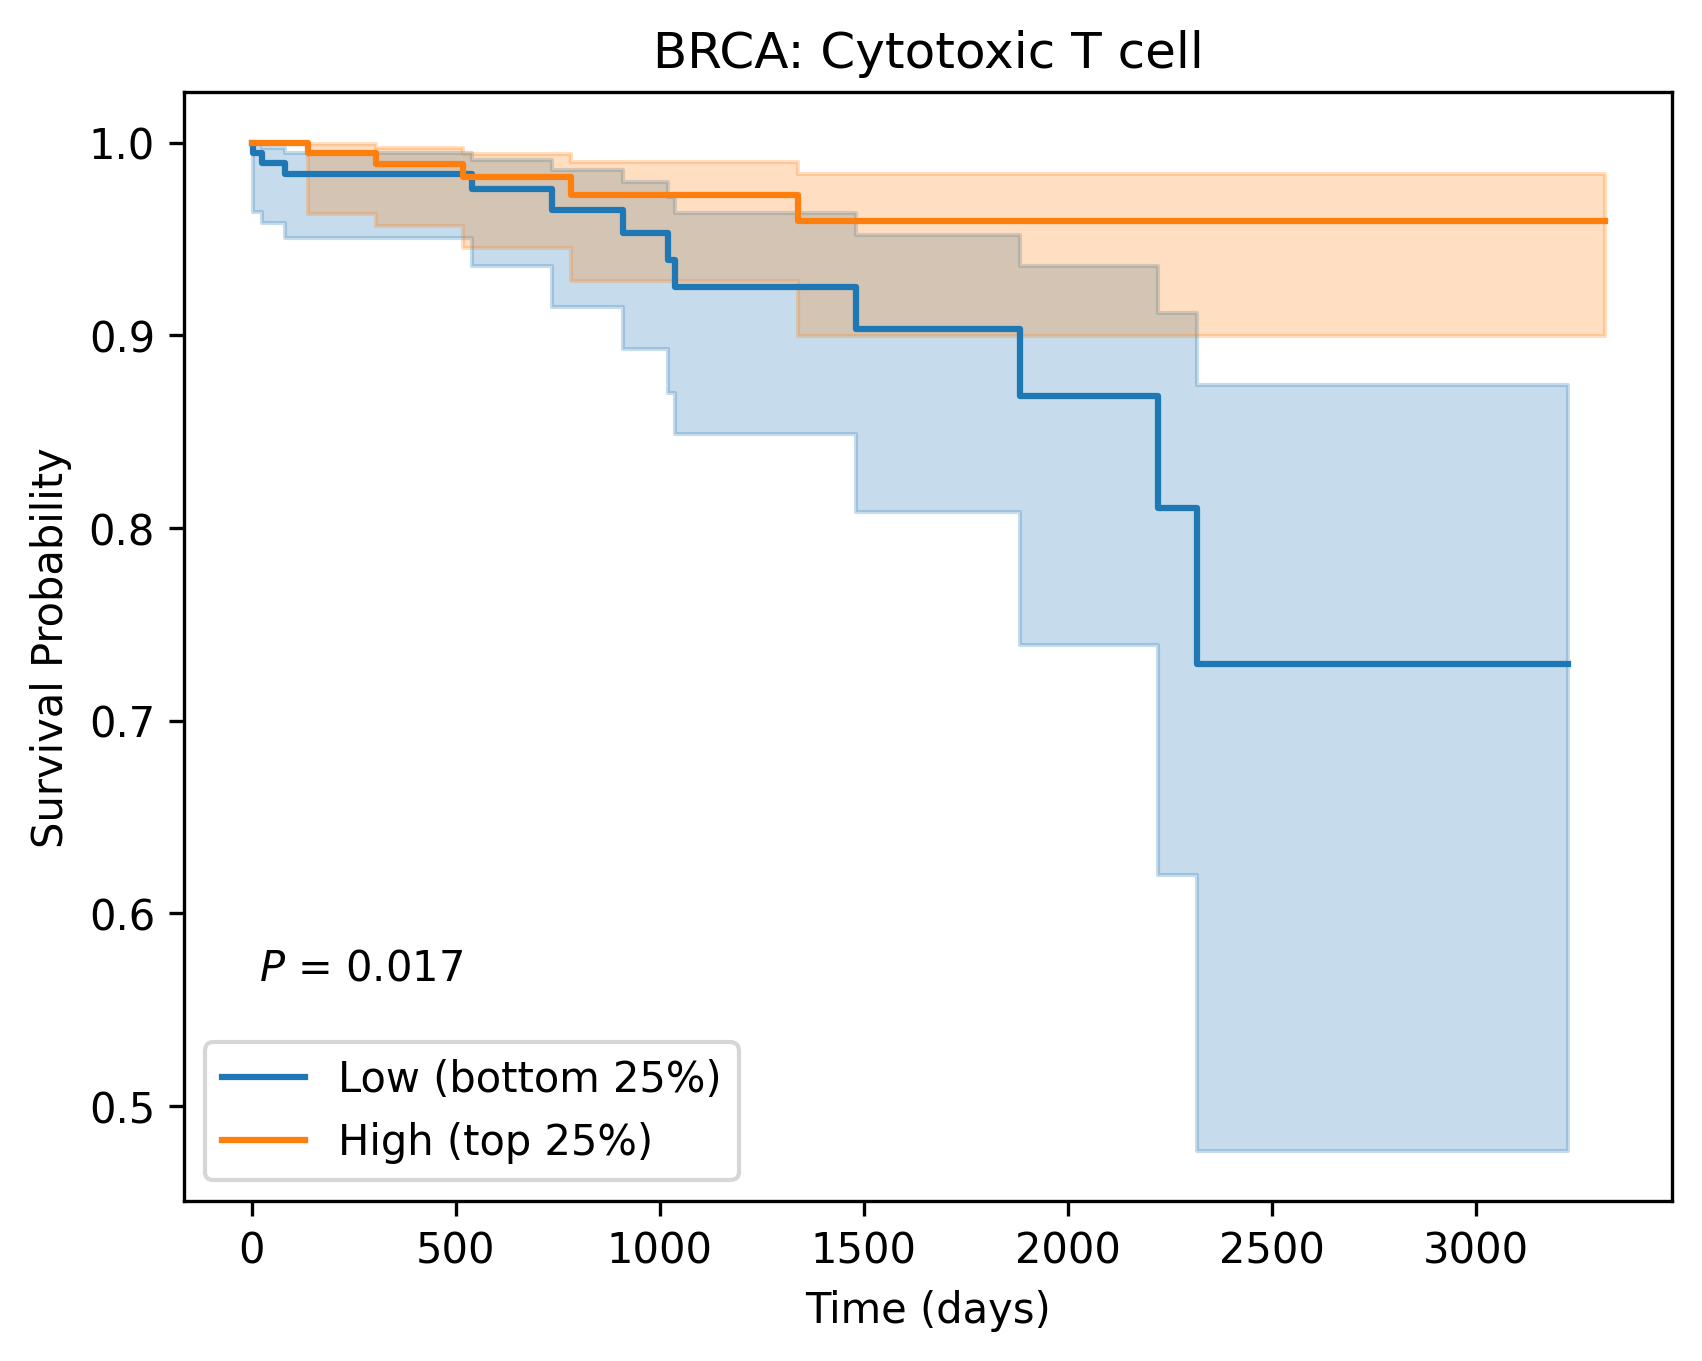

In [9]:
# select interesting cell types and re-analysis
target_summary = summary[summary['log-rank']<0.05]

dat = tu.TCGA_Analysis()
dat.set_data(exp=brca_df,deconv_res=deconv_res,clinical=clinical)
dat.preprocessing(lower_days=0,upper_days=3650)
for cell in target_summary.index:
    dat.calc_top_bottom(cell=cell,do_plot=True,title='BRCA: {}'.format(cell))